In [1]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession ,SQLContext, Row
from pyspark.sql import functions as F

import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
# In order to get the execution time 
st = time.time()

### Create SparkSession and setup sqlContext

In [3]:
conf = SparkConf().setAppName('OSM-Greece').setMaster('local[4]')
sc = SparkContext.getOrCreate(conf)
spark = SparkSession(sc)
spark

In [4]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

# the files have fields of binary type that must converted to string type in the phase of reading them
sqlContext.setConf("spark.sql.parquet.binaryAsString","true")

## 1. Read Files Node, Way, Relation and create the relevant DataFrames

In [5]:
# Path to local files
fileNode = "../ProjectDownloads/greece-latest.osm.pbf.node.parquet"
fileWay  = "../ProjectDownloads/greece-latest.osm.pbf.way.parquet"
fileRelation = "../ProjectDownloads/greece-latest.osm.pbf.relation.parquet"

# # Path to Google Storage files
# fileNode = "gs://osm_project/data/greece-latest.osm.pbf.node.parquet"
# fileWay  = "gs://osm_project/data/greece-latest.osm.pbf.way.parquet"
# fileRelation = "gs://osm_project/data/greece-latest.osm.pbf.relation.parquet"

### 1.1 Read and describe Node

In [6]:
osmNodeDs = sqlContext.read.parquet(fileNode)
# osmNodeDs = osmNodeDs.select('id', 'tags', 'latitude', 'longitude')
# osmNodeDs = osmNodeDs.select('*')
osmNodeDs.createOrReplaceTempView("osmNodeDs")

# Print Schema ans dample of rows
osmNodeDs.printSchema()
osmNodeDs.show(3)

# Print total rows of file Nodes 
print('Total rows of Nodes', osmNodeDs.count())

root
 |-- id: long (nullable = true)
 |-- version: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- changeset: long (nullable = true)
 |-- uid: integer (nullable = true)
 |-- user_sid: string (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

+-----+-------+-------------+---------+---+--------+----+------------------+------------------+
|   id|version|    timestamp|changeset|uid|user_sid|tags|          latitude|         longitude|
+-----+-------+-------------+---------+---+--------+----+------------------+------------------+
|78695|      6|1628655387000|        0|  0|        |  []|        37.5969196|        23.0706507|
|78696|      5|1628655387000|        0|  0|        |  []|37.595982400000004|23.071189800000003|
|78697|      5|1628655387000|   

### 1.2 Read and describe Way

In [7]:
osmWayDs = sqlContext.read.parquet(fileWay)
osmWayDs = osmWayDs.select('id', 'tags', 'nodes')
osmWayDs.createOrReplaceTempView("osmWayDs")

# Print Schema ans dample of rows
osmWayDs.printSchema()
osmWayDs.show(3)

# Print total rows of file Ways 
print('Total rows of Ways', osmWayDs.count())

root
 |-- id: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- nodes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = true)
 |    |    |-- nodeId: long (nullable = true)

+-------+--------------------+--------------------+
|     id|                tags|               nodes|
+-------+--------------------+--------------------+
|4263046|[{highway, tertia...|[{0, 78875}, {1, ...|
|4263047|[{highway, tertia...|[{0, 6651311048},...|
|4263048|[{highway, tertia...|[{0, 78810}, {1, ...|
+-------+--------------------+--------------------+
only showing top 3 rows

Total rows of Ways 2720538


### 1.3 Read and describe Relation

In [8]:
osmRelationDs = sqlContext.read.parquet(fileRelation)
osmRelationDs = osmRelationDs.select('id', 'tags', 'members')
osmRelationDs.createOrReplaceTempView("osmRelationDs")

# Print Schema ans dample of rows
osmRelationDs.printSchema()
osmRelationDs.show(3)

# Print total rows of file Ways 
print('Total rows of Relations', osmRelationDs.count())

root
 |-- id: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- members: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- role: string (nullable = true)
 |    |    |-- type: string (nullable = true)

+-----+--------------------+--------------------+
|   id|                tags|             members|
+-----+--------------------+--------------------+
| 2828|[{addr:city, Αθήν...|[{10741857, outer...|
|11759|[{name, MTB}, {ne...|[{23965337, , Way...|
|19467|[{name, Imbros Go...| [{24335429, , Way}]|
+-----+--------------------+--------------------+
only showing top 3 rows

Total rows of Relations 46167


## 2. Data Exploration

### 2.1 Sustenance, Education and Health categories
- Find amenities belong to the categories above 
- Create a DataFrame counting each one of them and 
- Plot a pie

In [9]:
listSustenance = ['pub', 'bar', 'restaurant', 'cafe', 'fast-food']
listEducation = ['college', 'kindergarten', 'driving_school', 'language_school', 'library', 'toy_library', 
                 'training', 'music_school', 'school', 'university']
listHealth = ['baby_hatch', 'clinic', 'dentist', 'doctors', 'hospital', 'nursing_home', 'pharmacy', 
          'social_facility', 'veterinary']

sustenance = osmNodeDs.filter((osmNodeDs.tags[0].key=='amenity') &
                              (osmNodeDs.tags[0].value.isin(listSustenance))) \
                      .select('id', 'tags') \
                      .withColumn('Category', F.lit('Sustenance'))

education = osmNodeDs.filter((osmNodeDs.tags[0].key=='amenity') &
                              (osmNodeDs.tags[0].value.isin(listEducation))) \
                     .select('id', 'tags') \
                     .withColumn('Category', F.lit('Education'))

health =    osmNodeDs.filter((osmNodeDs.tags[0].key=='amenity') &
                              (osmNodeDs.tags[0].value.isin(listHealth))) \
                     .select('id', 'tags') \
                     .withColumn('Category', F.lit('Health'))

cat3 = sustenance.union(education).union(health).groupBy('Category').count()
cat3.show(5)

+----------+-----+
|  Category|count|
+----------+-----+
|Sustenance|19032|
| Education| 1648|
|    Health| 3389|
+----------+-----+



([<matplotlib.patches.Wedge at 0x7f52bd9afe80>,
 [Text(-0.8707073566390022, 0.6722117963073257, 'Sustenance'),
  Text(0.49915287055108504, -0.9802277346722097, 'Education'),
  Text(0.994124282424508, -0.47086825237422547, 'Health')])

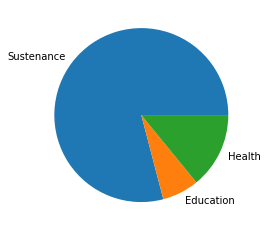

In [10]:
cat3df = cat3.toPandas()

plt.pie(
    cat3df['count'],
    labels=cat3df['Category'],
)

### 2.2 Visualize the top 15 categories of highways

In [11]:
osmWayDs.printSchema()

root
 |-- id: long (nullable = true)
 |-- tags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- key: string (nullable = true)
 |    |    |-- value: string (nullable = true)
 |-- nodes: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = true)
 |    |    |-- nodeId: long (nullable = true)



In [12]:
highway = osmWayDs.filter(osmWayDs.tags[0].key=='highway') \
                  .select(osmWayDs.tags[0].value.alias('Value')) \
                  .groupBy('Value').count().orderBy(F.col('count').desc()).limit(15)
highway.show()

+--------------+------+
|         Value| count|
+--------------+------+
|   residential|355584|
|         track|321226|
|       service|210141|
|  unclassified| 74149|
|      tertiary| 48839|
|       footway| 35154|
|     secondary| 33437|
|          path| 28706|
|       primary| 17694|
|    pedestrian|  9776|
|         steps|  8652|
| living_street|  5399|
|         trunk|  4178|
|secondary_link|  2179|
|      motorway|  1944|
+--------------+------+



<AxesSubplot:xlabel='Value'>

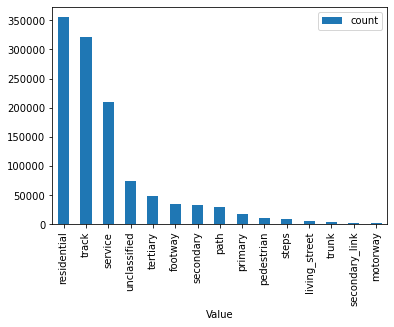

In [13]:
highwayDf = highway.toPandas()

highwayDf.plot.bar(x = 'Value', y = 'count')

In [14]:
et = time.time()
print('Execution time : ', et-st, 'seconds')

Execution time :  34.30276679992676 seconds
